# Detecting CAFO Expansion with PCA

Download images from Planet a year apart, then run PCA to see if there was a change. Implementing this [paper](https://ieeexplore-ieee-org.stanford.idm.oclc.org/stamp/stamp.jsp?tp=&arnumber=5196726&tag=1) by Celik (2009).

TODO:
- [] Compositing
- [] Build out loop
- [] Show change image
- [] Use PSScene4Band
- [] Use color

### Load modules

In [4]:
import os
import shutil
import time
import requests
from requests.auth import HTTPBasicAuth

from sklearn import decomposition
import numpy as np
import pandas as pd

import download
import random
import json
import math

import PIL
from PIL import Image
from PIL import TiffImagePlugin
TiffImagePlugin.DEBUG = True
from PIL import ImageChops

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (13, 8)
matplotlib.rcParams.update({'font.size': 18})

### Set API filter constants

In [5]:
ITEM_TYPE = 'PSScene3Band'
START_DATE = "2020-06-01T00:00:00.000Z"
END_DATE = "2020-07-01T00:00:00.000Z"
CLOUD_TOLERANCE = .01
CLEAR_PERCENT = 95

### Read coordinate csv
Testing with first entry

In [7]:
il_df = pd.read_csv('~/notebooks/home/il_06-11-20_ind.csv')

lat, lon = il_df.loc[0, ['lat', 'lon']]
coords = download.gen_box_coords(lat, lon)

### Show images
Currently converting to grayscale

In [ ]:
old_img = download.retrieve_planet_image(coords, 'old.tif', start_date='2019-06-01T00:00:00.000Z', end_date='2019-07-01T00:00:00.000Z', cloud_cover=CLOUD_TOLERANCE, clear_percent=CLEAR_PERCENT, item_type=ITEM_TYPE)
new_img = download.retrieve_planet_image(coords, 'new.tif', start_date='2020-06-01T00:00:00.000Z', end_date='2020-07-01T00:00:00.000Z', cloud_cover=CLOUD_TOLERANCE, clear_percent=CLEAR_PERCENT, item_type=ITEM_TYPE)

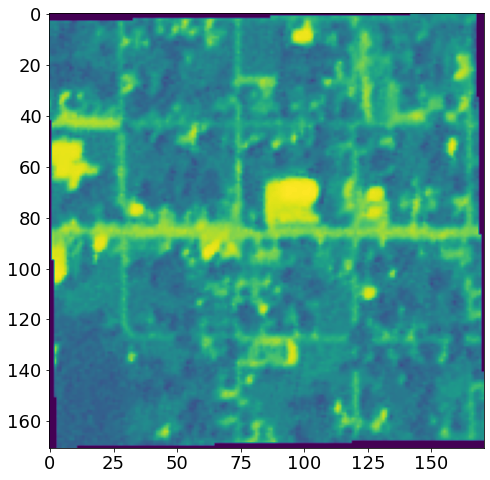

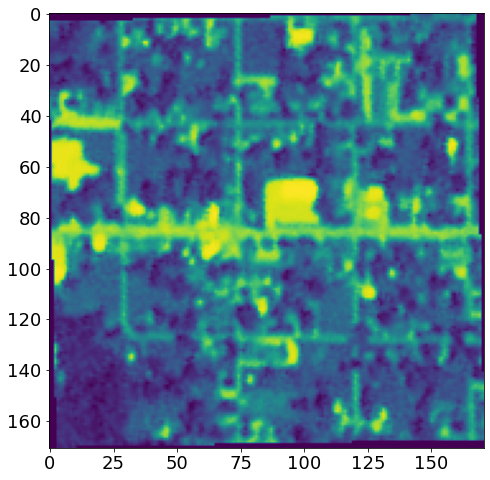

In [9]:
old_img = Image.open('old.tif').convert('L')
new_img = Image.open('new.tif').convert('L')
plt.imshow(old_img)
plt.show()
plt.imshow(new_img)
plt.show()

### Diff images

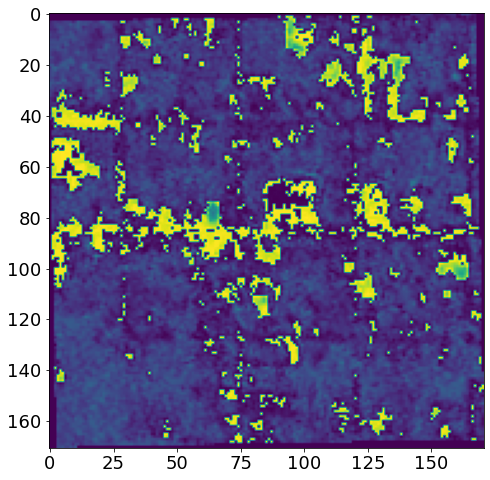

In [12]:
assert(old_img.size == new_img.size)
old_arr = np.array(old_img)
new_arr = np.array(new_img)

diff = np.subtract(old_arr, new_arr)

plt.imshow(diff)

### Break diff into h x h blocks, return blocks as column vectors in array

In [147]:
# set h >= 2
h = 3

column_block_list = np.array_split(diff_arr, h)
block_list = []
for column in column_block_list:
    # split column vertically and insert blocks into list
    block_list[0:0] = np.array_split(column, h, axis=1)

vectors = []
for block in block_list:
    vectors.append(block.ravel())

### Compute PCA on difference vector set to create eigenvector space (EVS)

In [150]:
# calculate mean vector
vector_arr = np.column_stack(vectors)
vector_arr.shape
mean_vector = np.mean(vector_arr, axis=1)

diff_vectors = []
for vector in vectors:
    diff_vectors.append(vector - mean_vector)

pca = decomposition.PCA()
pca.fit(diff_vectors)
EVS = pca.components_

### Create feature vector space (FVS) by projecting pixels of diff onto EVS